<a href="https://colab.research.google.com/github/ranitha84/cnn_assignment/blob/main/CNN_Skin_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Activation, MaxPooling2D,Dropout,Flatten,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from zipfile import ZipFile
from glob import glob

### Importing Skin Cancer Data

In [ ]:

## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
cnn_zip = '/content/gdrive/MyDrive/app/CNN_assignment.zip'
path_to_extract_folder ='/'
path_to_train_directory=path_to_extract_folder+'/Skin cancer ISIC The International Skin Imaging Collaboration/Train'

path_to_test_directory=path_to_extract_folder+'/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

In [ ]:
zf = ZipFile(cnn_zip, 'r')
zf.extractall(path_to_extract_folder)
zf.close()

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
seed= 123

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_dataset =  tf.keras.preprocessing.image_dataset_from_directory(image_size=(img_width,img_height),
                                                                seed=seed,
                                                                labels='inferred',
                                                                directory=data_dir_train,
                                                                batch_size=batch_size)

Found 2239 files belonging to 9 classes.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_dataset =tf.keras.preprocessing.image_dataset_from_directory(image_size=(img_width,img_height),
                                                            seed=seed,
                                                            labels='inferred',
                                                            directory=data_dir_test,
                                                            batch_size=batch_size)


Found 118 files belonging to 9 classes.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_dataset.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
- Visualizing one instance of all the nine classes present in the dataset

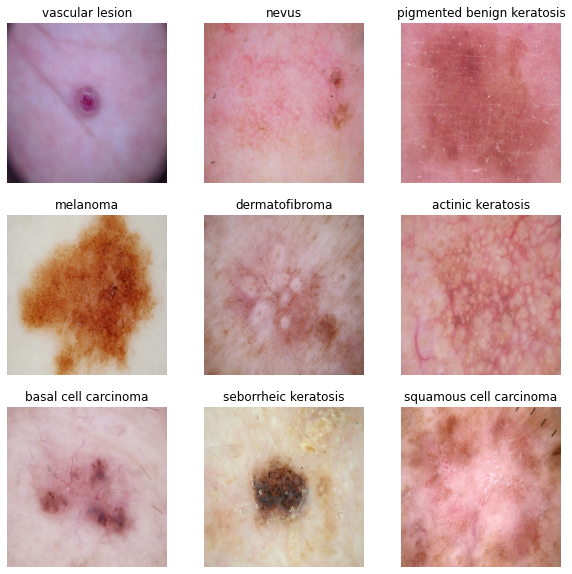

In [ ]:
import matplotlib.pyplot as plt
label_list = []

fig = plt.figure(figsize=(10,10))
counter = 0
n_rows=3
n_cols = 3
for images, labels in train_dataset.take(10):
    for i in range(len(class_names)):
        if int(labels[i]) not in label_list:
          counter = counter+1
          ax1 = fig.add_subplot(n_rows,n_cols,counter)
          ax1.imshow(images[i].numpy().astype("uint8"))
          plt.title(class_names[int(labels[i])])
          plt.axis("off")
          label_list.append(int(labels[i]))



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(train_ds)
print(val_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


### Create the model
- Lets now Create a CNN model, which can accurately detect 9 classes present in the dataset. 

- Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
input_shape = (img_height, img_width, 3)

vanilla_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape),
  layers.Conv2D(32, kernel_size=(3, 3),padding='same',activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, kernel_size=(3, 3), activation=keras.activations.relu),
  layers.MaxPooling2D(pool_size=(2,2)),


  layers.Conv2D(64, kernel_size=(3, 3),padding='same',  activation=keras.activations.relu),
  layers.BatchNormalization(),
  layers.Conv2D(64, kernel_size=(3, 3), activation=keras.activations.relu),
  layers.MaxPooling2D(pool_size=(2,2)),

  layers.Flatten(),
  layers.Dense(128, activation=keras.activations.relu),

  layers.Dense(num_classes,activation=keras.activations.softmax)
])



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
vanilla_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
vanilla_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 178, 178, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 89, 89, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 89, 89, 64)        2

### Train the plain vanilla model

In [ ]:
epochs = 20
vanilla_model_history = vanilla_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 33s 144ms/step - loss: 13.1294 - accuracy: 0.2429 - val_loss: 2.2056 - val_accuracy: 0.0932
Epoch 2/20
70/70 [==============================] - 5s 72ms/step - loss: 1.7059 - accuracy: 0.4202 - val_loss: 2.2477 - val_accuracy: 0.1441
Epoch 3/20
70/70 [==============================] - 5s 72ms/step - loss: 1.4666 - accuracy: 0.4963 - val_loss: 2.3137 - val_accuracy: 0.1864
Epoch 4/20
70/70 [==============================] - 5s 72ms/step - loss: 1.2649 - accuracy: 0.5599 - val_loss: 2.1922 - val_accuracy: 0.1695
Epoch 5/20
70/70 [==============================] - 5s 73ms/step - loss: 1.1377 - accuracy: 0.6130 - val_loss: 2.1682 - val_accuracy: 0.2797
Epoch 6/20
70/70 [==============================] - 5s 73ms/step - loss: 1.0157 - accuracy: 0.6467 - val_loss: 2.4349 - val_accuracy: 0.1610
Epoch 7/20
70/70 [==============================] - 5s 74ms/step - loss: 0.8261 - accuracy: 0.7089 - val_loss: 2.3756 - val_accuracy: 0.2712
Epoch 8/20

### Visualizing training results

In [ ]:
def plot_accuracy(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

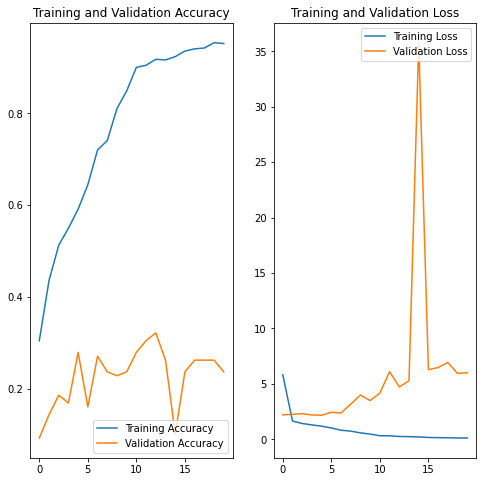

In [ ]:
plot_accuracy(vanilla_model_history)

#### **Findings**
  - It can be clearly seen that the model is over fitting in our case with training accuracy being very high and the valiation accuracy being very low. 

  - Both the training accuracy is high  while validation accuracy is very low when we train the model with the training and validation data

  - Lets now try different augmentation strategies to improve the model work accuracies

# Experiment 1
  - Data Augmentation with horizontal and random rotation and random zoom using Preprocessing technique available in tensorflow

### **Model Built Without Dropouts**


In [ ]:
resize_and_rescale = tf.keras.Sequential([
   layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape)
])

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
model_ag_do = Sequential()
model_ag_do.add(data_augmentation)
model_ag_do.add(resize_and_rescale)
model_ag_do.add(Conv2D(32, (3, 3), padding='same'))
model_ag_do.add(Activation('relu'))
model_ag_do.add(Conv2D(32, (3, 3)))
model_ag_do.add(Activation('relu'))
model_ag_do.add(MaxPooling2D(pool_size=(2, 2)))


model_ag_do.add(Conv2D(64, (3, 3), padding='same'))
model_ag_do.add(Activation('relu'))
model_ag_do.add(Conv2D(64, (3, 3)))
model_ag_do.add(Activation('relu'))
model_ag_do.add(MaxPooling2D(pool_size=(2, 2)))


model_ag_do.add(Flatten())
model_ag_do.add(Dense(128))
model_ag_do.add(Activation('relu'))
model_ag_do.add(Dense(len(class_names)))
model_ag_do.add(Activation('softmax'))

In [ ]:

model_ag_do.compile(optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

In [ ]:
model_ag_do.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 180, 180, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 178, 178, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 178, 178, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 89, 32)       

In [ ]:
history_augmentation1 = model_ag_do.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 6s 74ms/step - loss: 2.6062 - accuracy: 0.2482 - val_loss: 2.3216 - val_accuracy: 0.1525
Epoch 2/20
70/70 [==============================] - 5s 72ms/step - loss: 1.7059 - accuracy: 0.3744 - val_loss: 2.0430 - val_accuracy: 0.2881
Epoch 3/20
70/70 [==============================] - 5s 72ms/step - loss: 1.5444 - accuracy: 0.4859 - val_loss: 2.0488 - val_accuracy: 0.2966
Epoch 4/20
70/70 [==============================] - 5s 72ms/step - loss: 1.4144 - accuracy: 0.5011 - val_loss: 2.1926 - val_accuracy: 0.3220
Epoch 5/20
70/70 [==============================] - 5s 73ms/step - loss: 1.4046 - accuracy: 0.5296 - val_loss: 2.2671 - val_accuracy: 0.3136
Epoch 6/20
70/70 [==============================] - 5s 73ms/step - loss: 1.3910 - accuracy: 0.5075 - val_loss: 2.3923 - val_accuracy: 0.3136
Epoch 7/20
70/70 [==============================] - 5s 73ms/step - loss: 1.3302 - accuracy: 0.5325 - val_loss: 2.1405 - val_accuracy: 0.3475
Epoch 8/20
70

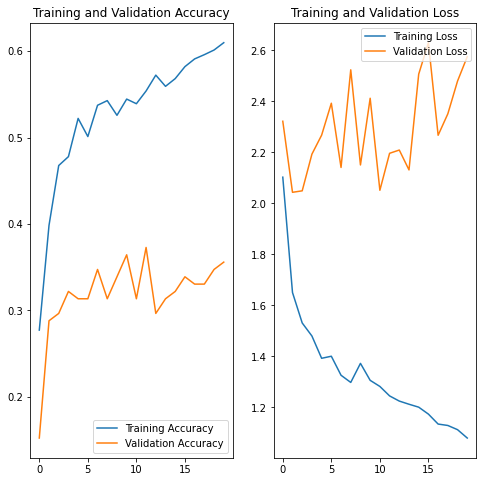

In [ ]:
plot_accuracy(history_augmentation1)

#### **Findings**

- We can see that the model is overfitting. The training accuracy is high while the validation accuracy is very low.

- We see a drop in training accuracy after rescaling and zooming the images. This is expected since the training data is modified by the preprocessing steps we have introduced

- Lets try to tune the model with the Dropout techniques and see whether there is any improvement to the model

# Experiment 2 
- We still see the model overfitting. Lets try to add dropout layers and see whether the overfitting problem is tackled or not.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
model_ag1_do = Sequential()

model_ag1_do.add(data_augmentation)
model_ag1_do.add(resize_and_rescale)


model_ag1_do.add(Conv2D(32, (3, 3), padding='same'))
model_ag1_do.add(Activation('relu'))
model_ag1_do.add(Conv2D(32, (3, 3)))
model_ag1_do.add(Activation('relu'))
model_ag1_do.add(MaxPooling2D(pool_size=(2, 2)))
model_ag1_do.add(Dropout(0.25))

model_ag1_do.add(Conv2D(64, (3, 3), padding='same'))
model_ag1_do.add(Activation('relu'))
model_ag1_do.add(Conv2D(64, (3, 3)))
model_ag1_do.add(Activation('relu'))
model_ag1_do.add(MaxPooling2D(pool_size=(2, 2)))
model_ag1_do.add(Dropout(0.4))

model_ag1_do.add(Flatten())
model_ag1_do.add(Dense(128))
model_ag1_do.add(Activation('relu'))
model_ag1_do.add(Dropout(0.5))

model_ag1_do.add(Dense(len(class_names)))
model_ag1_do.add(Activation('softmax'))



# Compile the Model

In [ ]:

model_ag1_do.compile(optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

In [ ]:
model_ag1_do.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
activation_14 (Activation)   (None, 180, 180, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 178, 178, 32)      9248      
_________________________________________________________________
activation_15 (Activation)   (None, 178, 178, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 89, 89, 32)       

In [ ]:
history_augmentation2 = model_ag1_do.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
70/70 [==============================] - 6s 77ms/step - loss: 2.3908 - accuracy: 0.1783 - val_loss: 2.2070 - val_accuracy: 0.1695
Epoch 2/20
70/70 [==============================] - 5s 75ms/step - loss: 1.9392 - accuracy: 0.2746 - val_loss: 2.2191 - val_accuracy: 0.2373
Epoch 3/20
70/70 [==============================] - 5s 75ms/step - loss: 1.7781 - accuracy: 0.3522 - val_loss: 2.1564 - val_accuracy: 0.2458
Epoch 4/20
70/70 [==============================] - 5s 75ms/step - loss: 1.7190 - accuracy: 0.3671 - val_loss: 2.0505 - val_accuracy: 0.3220
Epoch 5/20
70/70 [==============================] - 5s 76ms/step - loss: 1.6569 - accuracy: 0.4094 - val_loss: 2.0405 - val_accuracy: 0.2542
Epoch 6/20
70/70 [==============================] - 5s 76ms/step - loss: 1.6215 - accuracy: 0.4293 - val_loss: 2.1182 - val_accuracy: 0.3136
Epoch 7/20
70/70 [==============================] - 5s 76ms/step - loss: 1.6291 - accuracy: 0.4248 - val_loss: 2.0694 - val_accuracy: 0.2797
Epoch 8/20
70

### Visualizing the results

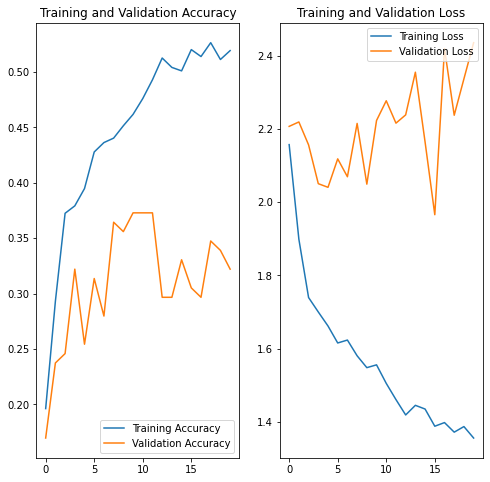

In [ ]:
plot_accuracy(history_augmentation2)


# Findings :

Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- We see some improvement in the difference between the training and validation accuracy after we added the Dropout layers. Lets further analyze on how to improve the model further

- Still we see the model overfits though comparatively better than the previous **run**

- However the training accuracy and the validation accuracy is not what we expect it to be. 

- Lets try to find the class distribution of the training data set and Augment them 

## Find the distribution of classes in the training dataset.

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
# Method to find tjhe 
classes_dict = {0:'actinic keratosis', 
                1:'basal cell carcinoma', 
                2:'dermatofibroma', 
                3:'melanoma', 
                4:'nevus', 
                5:'pigmented benign keratosis', 
                6:'seborrheic keratosis', 
                7:'squamous cell carcinoma', 
                8:'vascular lesion'}

def count_class(counts, batch, num_classes=9):
    labels = batch[1]
    for i in range(num_classes):
        cc = tf.cast(labels == i, tf.int32)
        counts[i] += tf.reduce_sum(cc)
    return counts

initial_state = dict((i, 0) for i in range(num_classes))

counts = train_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

classification = []
count = []
for k,v in counts.items():
  if k in classes_dict.keys():
    classification.append(classes_dict[k])
    count.append(v.numpy())
    
dict_ds = {'Classification':classification, 'Count':count}

classification_ds = pd.DataFrame(data=dict_ds, columns=['Classification', 'Count'])
classification_ds.head(10)




,Classification,Count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Figure size 1080x1080 with 0 Axes>

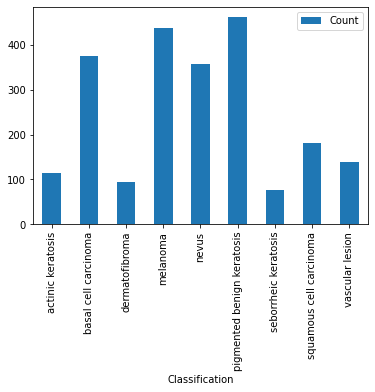

In [ ]:

plt.figure(figsize=(15,15))
classification_ds.plot.bar(x='Classification', y='Count')
plt.show()

#### **Findings**: 
#### - We can clearly see that <mark>seborrheic keratosis</mark> has the least number of samples(77)
#### - <mark>Pigmented benign keratosis</mark>	dominates with highest number(462) of samples available for it 


#### Lets now  Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:

print(data_dir_train)
path_to_training_dataset=path_to_train_directory+'/'
import Augmentor
for i in class_names:
    print(i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F013A12C3C8>:   0%|          | 1/500 [00:00<00:59,  8.34 Samples/s]

//Skin cancer ISIC The International Skin Imaging Collaboration/Train
actinic keratosis
Initialised with 114 image(s) found.
Output directory set to //Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F013A00C080>: 100%|██████████| 500/500 [00:17<00:00, 28.24 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F013A00CA20>:   0%|          | 1/500 [00:00<00:59,  8.38 Samples/s]

basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to //Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F013A090B38>: 100%|██████████| 500/500 [00:18<00:00, 27.76 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

dermatofibroma
Initialised with 95 image(s) found.
Output directory set to //Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F013A0FE6D8>: 100%|██████████| 500/500 [00:17<00:00, 27.94 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

melanoma
Initialised with 438 image(s) found.
Output directory set to //Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F013A0CF400>: 100%|██████████| 500/500 [01:42<00:00,  4.87 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

nevus
Initialised with 357 image(s) found.
Output directory set to //Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F013A0C0470>: 100%|██████████| 500/500 [01:26<00:00,  5.76 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to //Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F013A0FE898>: 100%|██████████| 500/500 [00:17<00:00, 27.82 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to //Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F013A1B0BE0>: 100%|██████████| 500/500 [00:44<00:00, 11.22 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to //Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F013A0FC7F0>: 100%|██████████| 500/500 [00:17<00:00, 28.27 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

vascular lesion
Initialised with 139 image(s) found.
Output directory set to //Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F013A0B3198>: 100%|██████████| 500/500 [00:17<00:00, 27.88 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_old = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

path_list_old

['//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0025780.jpg',
 '//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000525.jpg',
 '//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000234.jpg',
 '//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000498.jpg',
 '//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000327.jpg',
 '//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000325.jpg',
 '//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000316.jpg',
 '//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000315.jpg',
 '//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000240.jpg',
 '//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000458.jpg',
 '//Skin cancer ISIC The Inter

In [ ]:
lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]
lesion_list_old

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [ ]:
dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))

In [ ]:
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000064.jpg_a0368755-409b-4029-8148-2634b4403bd8.jpg',
 '//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000407.jpg_26e5b3a2-29eb-4883-80fe-1dfee83ed316.jpg',
 '//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000240.jpg_c35ab66e-443a-4e0c-9e47-fe8c6d94d66f.jpg',
 '//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000508.jpg_f89810e9-2ef4-4007-9e51-85a36457864a.jpg',
 '//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000500.jpg_ecdb011e-8d46-4a43-8b16-3c8419865a08.jpg',
 '//Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000081.jpg_0af5c39c-4390-44ac-9dcd-fb9400534310.jpg',
 '//Skin cancer ISIC The International S

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

##### Training the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating training dataset with the augmented **data**

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


##### Creating validation dataset from the augmented **data**

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


##### Creating model including **batch normalization and Dropouts as regularization methods**





In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
model_ag2_do = Sequential()

model_ag2_do.add(resize_and_rescale)

model_ag2_do.add(Conv2D(16, (3, 3), padding='same'))
model_ag2_do.add(Activation('relu'))
model_ag2_do.add(Conv2D(16, (3, 3), padding='same'))
model_ag2_do.add(Activation('relu'))
model_ag2_do.add(MaxPooling2D(pool_size=(2, 2)))
model_ag2_do.add(Dropout(0.25))

model_ag2_do.add(Conv2D(32, (3, 3), padding='same'))
model_ag2_do.add(Activation('relu'))
model_ag2_do.add(Conv2D(32, (3, 3), padding='same'))
model_ag2_do.add(Activation('relu'))
model_ag2_do.add(MaxPooling2D(pool_size=(2, 2)))
model_ag2_do.add(Dropout(0.25))

model_ag2_do.add(Conv2D(64, (3, 3), padding='same'))
model_ag2_do.add(Activation('relu'))
model_ag2_do.add(Conv2D(64, (3, 3), padding='same'))
model_ag2_do.add(Activation('relu'))
model_ag2_do.add(MaxPooling2D(pool_size=(2, 2)))
model_ag2_do.add(Dropout(0.4))

model_ag2_do.add(Flatten())
model_ag2_do.add(Dense(128))
model_ag2_do.add(Activation('relu'))
model_ag2_do.add(Dropout(0.5))

model_ag2_do.add(Dense(len(class_names)))
model_ag2_do.add(Activation('softmax'))

####  Compiling the model 

- Optimizer choosen is <mark>Adam and SparseCategoricalCrossEnjtropy is used for looses</mark>

In [ ]:
model_ag2_do.compile(optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

In [ ]:
model_ag2_do.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 180, 180, 16)      448       
_________________________________________________________________
activation_146 (Activation)  (None, 180, 180, 16)      0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 180, 180, 16)      2320      
_________________________________________________________________
activation_147 (Activation)  (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 90, 90, 16)      

####  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model_ag2_do.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 9s 46ms/step - loss: 2.0906 - accuracy: 0.1879 - val_loss: 1.9113 - val_accuracy: 0.2383
Epoch 2/50
169/169 [==============================] - 7s 44ms/step - loss: 1.8160 - accuracy: 0.2758 - val_loss: 1.6377 - val_accuracy: 0.4224
Epoch 3/50
169/169 [==============================] - 7s 44ms/step - loss: 1.6281 - accuracy: 0.3746 - val_loss: 1.4888 - val_accuracy: 0.4321
Epoch 4/50
169/169 [==============================] - 7s 44ms/step - loss: 1.5985 - accuracy: 0.3818 - val_loss: 1.4315 - val_accuracy: 0.4395
Epoch 5/50
169/169 [==============================] - 7s 44ms/step - loss: 1.5303 - accuracy: 0.4192 - val_loss: 1.3967 - val_accuracy: 0.4551
Epoch 6/50
169/169 [==============================] - 7s 43ms/step - loss: 1.4234 - accuracy: 0.4368 - val_loss: 1.5194 - val_accuracy: 0.4714
Epoch 7/50
169/169 [==============================] - 7s 43ms/step - loss: 1.4187 - accuracy: 0.4376 - val_loss: 1.2817 - val_accuracy: 0.5078

#####   Visualizing the model results after data augmentation

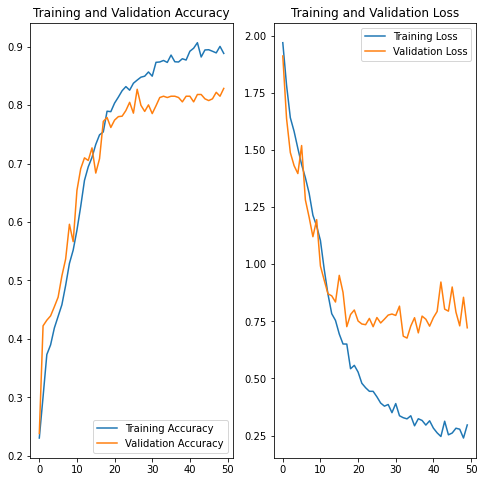

In [ ]:
plot_accuracy(history)

#### **Final Analysis**

- Here after applying augmentation, we can clearly see that both the training and validation accuracy has improved

- Few fine tuning techniques adapted were: 
    - Using Augmentor we added 500 images to each data set to address the class imbalance
    - Additional layer was added to augment the training of the model
    - Dropout layers were fine tuned to address over fitting problem
    - In addition to all this 50 epochs were used for training the data set

- We are getting around **<mark>88% training accuracy and 83% validation accuracy.</mark>**

- Overall training and validation accuracy has improved after applying the the augmentation techniques

- We can see that the **overfitting problem we faced in the earlier models** have been averted by adding more data to the training data set


